In [0]:
!pip install -q --no-cache-dir --upgrade git+https://github.com/tumido/face_biometrics_descriptor-code.git
  
from sklearn.datasets import fetch_lfw_people
from capsnet import preprocess, CapsNet, fetch_pins_people

!pip show capsnet

Using TensorFlow backend.


Name: capsnet
Version: 0.4.1
Summary: CapsNet - face recognition
Home-page: UNKNOWN
Author: Tomas Coufal
Author-email: UNKNOWN
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: tensorflow, keras, scikit-learn, numpy
Required-by: 


In [0]:
import numpy as np
from sklearn.metrics import confusion_matrix
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from random import randint

!pip install -q kaggle
from getpass import getpass

from google.colab import drive
drive.mount('/content/gdrive')
!mkdir -p "/content/gdrive/My Drive/models"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!pip install -q tensorboardcolab
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback

tbc = TensorBoardColab()
tensor_board_callback = TensorBoardColabCallback(tbc, batch_size=10, histogram_freq=5, write_graph=True, write_grads=True, write_images=True)

Wait for 8 seconds...
TensorBoard link:
https://ef1fe09b.ngrok.io


In [0]:
from tensorflow.test import is_gpu_available
from tensorflow.python.client import device_lib

if not is_gpu_available():
    raise SystemError('GPU device not found')

desc = [f'path: {d.name}, {d.physical_device_desc}' for d in device_lib.list_local_devices() if d.device_type == "GPU"][0]
print("\n".join(desc.split(", ")))

path: /device:GPU:0
device: 0
name: Tesla K80
pci bus id: 0000:00:04.0
compute capability: 3.7


In [0]:
#dataset = input('Which dataset to use?\n1) Labeled Faces in the Wild (default)\n2) Aligned Face Dataset from Pinterest\n')
dataset = '1'
if dataset is '2':
    user = input('Kaggle Username: ')
    key = getpass('Kaggle API key: ')

    kaggle_json = f'{{"username":"{user}","key":"{key}"}}'

    !mkdir -p /root/.kaggle
    with open('/root/.kaggle/kaggle.json', 'w') as f:
        f.write(kaggle_json)

    !chmod 600 /root/.kaggle/kaggle.json
    !kaggle config set -n path -v /content/kaggle
    !mkdir -p /content/kaggle

In [0]:
dataset = '1'
if dataset is '2':
    people = fetch_pins_people(
        color=True,
        min_faces_per_person=110  # Limit number of identities to ~50 (network is too large otherwise)
    )
    
else:
    people = fetch_lfw_people(
        color=True,
        min_faces_per_person=25
    )


data = preprocess(people)
(x_train, y_train), (x_test, y_test) = data

In [0]:
metrics = {
    "Identities": len(np.unique(people.target, axis=0)),
    "Total images": people.target.shape[0],
    "Train images": len(y_train),
    "Test images": len(y_test),
    "Image shape": x_train.shape[1:]
}
pd.DataFrame.from_dict(metrics, columns=["Value"], orient='index')

,Value
Identities,42
Total images,2588
Train images,2070
Test images,518
Image shape,"(32, 32, 3)"


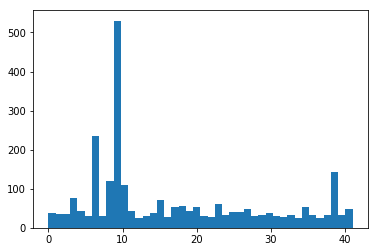

In [0]:
_ = plt.hist(people.target, bins=people.target_names.shape[0])

39: Tony Blair


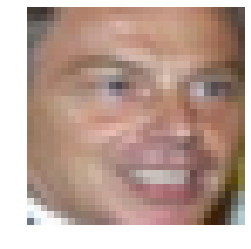

In [0]:
i = randint(0, len(x_train))
plt.imshow(x_train[i])
plt.axis('off') 
print("{}: {}".format(np.argmax(y_train[i]), people.target_names[np.argmax(y_train[i])]))

In [0]:
model = CapsNet(
    x_train.shape[1:],
    len(np.unique(y_train, axis=0)),
    routing_iters=3,
    #kernel_initializer=initializers.random_normal(stddev=0.01, seed=0),
    dropout_rate=.7,
    init_conv_filters=256,
    init_conv_kernel=9,
    feature_caps_kernel=5,
    feature_caps_dim=16,
    feature_caps_channels=16,
    prediction_caps_dim=32,
    image_size=(32, 32)
)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
encoder_conv2d (Conv2D)         (None, 24, 24, 256)  62464       input_image[0][0]                
__________________________________________________________________________________________________
encoder_dropout (Dropout)       (None, 24, 24, 256)  0           encoder_conv2d[0][0]             
__________________________________________________________________________________________________
encoder_feature_caps_

In [11]:
history = model.train(data, batch_size=10, extra_callbacks=[tensor_board_callback])

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/200
207/207 [==============================] - 174s 841ms/step - loss: 0.7779 - capsnet_loss: 0.7777 - decoder_loss: 0.2424 - capsnet_acc: 0.1179 - val_loss: 0.8077 - val_capsnet_loss: 0.8076 - val_decoder_loss: 0.1147 - val_capsnet_acc: 0.0097

Epoch 00001: val_capsnet_acc improved from -inf to 0.00965, saving model to model/weights.01.h5
Epoch 2/200
207/207 [==============================] - 169s 814ms/step - loss: 0.7726 - capsnet_loss: 0.7726 - decoder_loss: 0.0909 - capsnet_acc: 0.1203 - val_loss: 0.7760 - val_capsnet_loss: 0.7760 - val_decoder_loss: 0.0865 - val_capsnet_acc: 0.1988

Epoch 00002: val_capsnet_acc improved from 0.00965 to 0.19884, saving model to model/weights.02.h5
Epoch 3/200
207/207 [==============================] - 168s 811ms/step - loss: 0.7269 - capsnet_loss: 0.7269 - decoder_loss: 0.0863 - capsnet_acc: 0.1990 - val_loss: 0.728

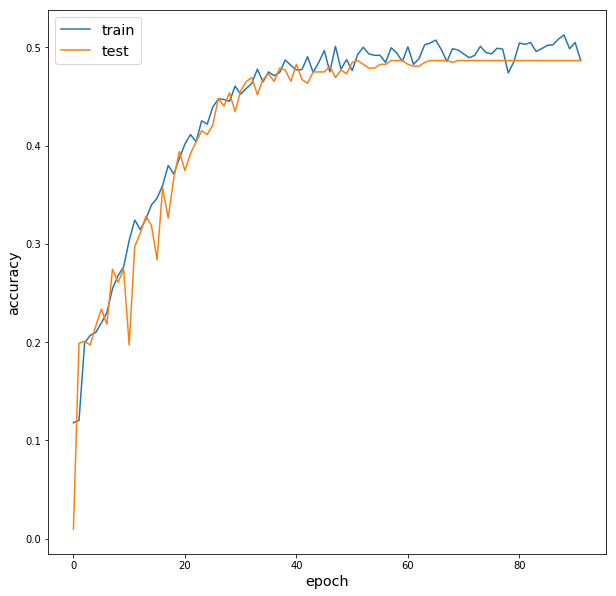

In [14]:
plt.figure(figsize=(10, 10))
plt.plot(history.history['capsnet_acc'])
plt.plot(history.history['val_capsnet_acc'])
plt.ylabel('accuracy', fontsize='x-large')
plt.xlabel('epoch', fontsize='x-large')
plt.legend(['train', 'test'], loc='upper left', fontsize='x-large')

In [13]:
model.save(f'/content/gdrive/My Drive/models')

Saving model as 2019-05-14_48.tar.gz...
	Saving "train" architecture... Done
	Saving "test" architecture... Done
	Saving weights... Done
